# 迁移学习

迁移学习是在一个任务上训练的模型被用于不同但相关的任务。在 PyTorch 中，进行迁移学习通常包括以下步骤：

- 加载预训练模型： 使用一个在大规模数据集上训练过的模型，例如 ImageNet 上的预训练模型。

- 修改模型架构： 修改加载的模型以适应新任务。这可能包括调整输出层的大小，冻结一些层，或者替换一些层。

- 定义新任务： 定义新任务的数据集和相应的损失函数。

- 训练模型： 使用新任务的数据集对修改后的模型进行训练。

In [29]:
import datetime as dt
import os
import warnings
from collections import UserDict
from tqdm import tqdm # 打印进度条

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 两种绘图接口
import plotly_express as px
import plotly.graph_objects as go

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.nn.utils import weight_norm

%matplotlib inline

warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)

## 模型微调

### 加载预训练模型

In [25]:
# 定义预训练模型
import sys
path = '../models' #项目所在文件夹
sys.path.insert(0, path)

from lstm import LSTM
model_path = '../models/best_models/lstm.pth'
pretrained_model = torch.load(model_path)

### 修改模型架构

#### 冻结层

In [26]:
# 输出模型参数的requires_grad属性
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

lstm.weight_ih_l0: True
lstm.weight_hh_l0: True
lstm.bias_ih_l0: True
lstm.bias_hh_l0: True
linear.weight: True
linear.bias: True


lstm、linear表示层的别名。

weight_ih_l0表示LSTM模型的输入到隐藏层的权重参数。

weight_hh_l0表示LSTM隐藏层到隐藏层的权重。

In [27]:
# 冻结部分层
for name, param in model.named_parameters():
    if name.startswith('lstm'):  # 在这个示例中冻结别名为lstm的层
        param.requires_grad = False

In [28]:
# 输出模型参数的requires_grad属性（已冻结的层的requires_grad应为False）
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

lstm.weight_ih_l0: False
lstm.weight_hh_l0: False
lstm.bias_ih_l0: False
lstm.bias_hh_l0: False
linear.weight: True
linear.bias: True


#### 替换层

In [14]:
# 修改模型架构，这里假设输出层需要调整为新任务的输出维度
new_out_dim = 1
pretrained_model.linear = nn.Linear(in_features=5, out_features=new_out_dim)

### 定义新任务

#### 定义新数据集

将在load上训练的模型应用在temp上。

In [9]:
ts_data = pd.read_csv("../data/energy.csv")
ts_data = pd.DataFrame(ts_data[["load", "temp"]].values, index=pd.to_datetime(ts_data["Unnamed: 0"].values), columns=["load", "temp"])
ts_data = ts_data.asfreq(freq='H') #转换为小时频率的数据
ts_data.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [10]:
# 包含时间维度的数据集划分
def divide_dataset(df, test_date, valid_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [11]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["temp"],
    "y_feature_list": ["temp"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 1) y_train shape: (23376, 1)
x_valid shape: (1464, 1) y_valid shape: (1464, 1)
x_test shape: (1464, 1) y_test shape: (1464, 1)


In [12]:
#利用前lookback个数据，预测下delay个数据
def rnn_create_dataset(feature, target, lookback, delay, step, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据
    for i in range(lookback, len(feature) - delay, step):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X) # X为三维
    y = torch.as_tensor(y) 
    y = y.squeeze(dim=2) #去掉维度为1的第三维度，将其变为二维
    #创建dataloader
    loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [13]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 1,
    "step": 1, #确保后续画图不出错
    "batch_size": 32,
}
X_train, y_train, train_loader = rnn_create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = rnn_create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = rnn_create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23370, 6, 1]),y_size: torch.Size([23370, 1]),loader_len: 731
X_size: torch.Size([1458, 6, 1]),y_size: torch.Size([1458, 1]),loader_len: 46
X_size: torch.Size([1458, 6, 1]),y_size: torch.Size([1458, 1]),loader_len: 46


### 训练模型

In [15]:
def train(pretrained_model, train_loader, valid_loader, n_epochs, verbose=True, plots=True):
#     #LSTM
#     class LSTM(nn.Module):
#         def __init__(self, input_dim, out_dim):
#             super(LSTM, self).__init__()
#             self.lstm = nn.LSTM(input_size=input_dim, hidden_size=5, num_layers=1, batch_first=True)
#             self.linear = nn.Linear(in_features=5, out_features=out_dim)
#         def forward(self, x):
#             lstm_out, _ = self.lstm(x)
#             last_time_step_output = lstm_out[:, -1, :]
#             output = self.linear(last_time_step_output)
#             return output
        
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    #训练模型
    model = pretrained_model
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()

    # 损失函数值
    train_losses, val_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch)
            outputs = outputs
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    #绘制损失函数图
    if plots:
        plot_loss(train_losses, val_losses)
    return model

In [16]:
#损失函数图
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(val_losses, linestyle='-',color = '#11b3b6')
    plt.plot(train_losses, linestyle='-',color = '#f14643')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Progress")
    plt.legend(["Validation", "Training"])
    plt.show()

  5%|████▏                                                                              | 1/20 [00:01<00:29,  1.56s/it]

Epoch [1/20], Training Loss: 0.0164, Validation Loss: 0.0019


 10%|████████▎                                                                          | 2/20 [00:02<00:26,  1.45s/it]

Epoch [2/20], Training Loss: 0.0004, Validation Loss: 0.0016


 15%|████████████▍                                                                      | 3/20 [00:04<00:23,  1.41s/it]

Epoch [3/20], Training Loss: 0.0003, Validation Loss: 0.0013


 20%|████████████████▌                                                                  | 4/20 [00:05<00:22,  1.41s/it]

Epoch [4/20], Training Loss: 0.0003, Validation Loss: 0.0011


 25%|████████████████████▊                                                              | 5/20 [00:07<00:21,  1.43s/it]

Epoch [5/20], Training Loss: 0.0002, Validation Loss: 0.0009


 30%|████████████████████████▉                                                          | 6/20 [00:08<00:20,  1.47s/it]

Epoch [6/20], Training Loss: 0.0002, Validation Loss: 0.0008


 35%|█████████████████████████████                                                      | 7/20 [00:10<00:19,  1.46s/it]

Epoch [7/20], Training Loss: 0.0002, Validation Loss: 0.0007


 40%|█████████████████████████████████▏                                                 | 8/20 [00:11<00:17,  1.47s/it]

Epoch [8/20], Training Loss: 0.0002, Validation Loss: 0.0007


 45%|█████████████████████████████████████▎                                             | 9/20 [00:13<00:16,  1.54s/it]

Epoch [9/20], Training Loss: 0.0001, Validation Loss: 0.0007


 50%|█████████████████████████████████████████                                         | 10/20 [00:15<00:16,  1.63s/it]

Epoch [10/20], Training Loss: 0.0001, Validation Loss: 0.0007


 55%|█████████████████████████████████████████████                                     | 11/20 [00:16<00:14,  1.64s/it]

Epoch [11/20], Training Loss: 0.0001, Validation Loss: 0.0007


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:18<00:13,  1.64s/it]

Epoch [12/20], Training Loss: 0.0001, Validation Loss: 0.0007


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:19<00:11,  1.60s/it]

Epoch [13/20], Training Loss: 0.0001, Validation Loss: 0.0007


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:21<00:09,  1.57s/it]

Epoch [14/20], Training Loss: 0.0001, Validation Loss: 0.0007


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:22<00:07,  1.54s/it]

Epoch [15/20], Training Loss: 0.0001, Validation Loss: 0.0007


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:24<00:06,  1.53s/it]

Epoch [16/20], Training Loss: 0.0001, Validation Loss: 0.0007


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:25<00:04,  1.53s/it]

Epoch [17/20], Training Loss: 0.0001, Validation Loss: 0.0007


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:27<00:03,  1.57s/it]

Epoch [18/20], Training Loss: 0.0001, Validation Loss: 0.0007


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:29<00:01,  1.56s/it]

Epoch [19/20], Training Loss: 0.0001, Validation Loss: 0.0007


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:30<00:00,  1.54s/it]

Epoch [20/20], Training Loss: 0.0001, Validation Loss: 0.0007


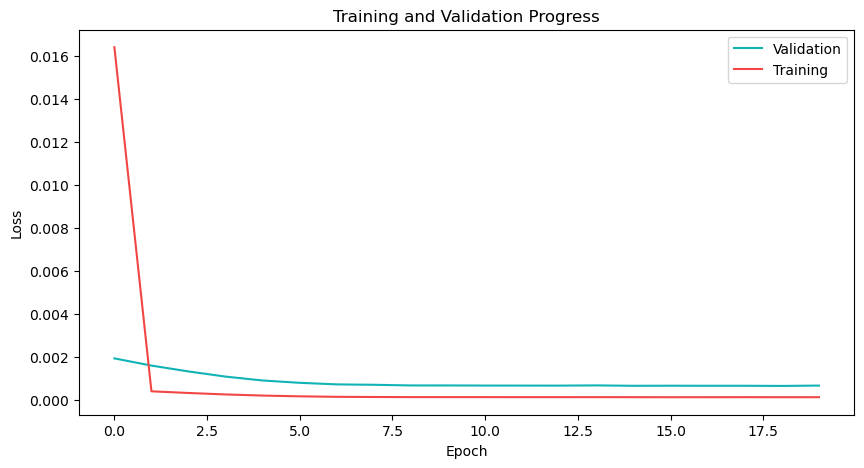

In [17]:
# 构造参数字典
params3 = {
    "pretrained_model": pretrained_model,
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 20,
    "verbose": True,
    "plots": True,
}
model = train(**params3)

### 保存迁移学习后的模型

In [18]:
torch.save(model, "../models/best_models/transfer_learned_model.pth")

### 加载新模型

In [19]:
# 定义预训练模型
import sys
path = '../models' #项目所在文件夹
sys.path.insert(0, path)

from lstm import LSTM
model_path = '../models/best_models/transfer_learned_model.pth'
new_model = torch.load(model_path)

## 模型定义

### 训练预训练模型

In [30]:
def train(train_loader, valid_loader, n_epochs, input_dim, out_dim, verbose=True, plots=True):
    #LSTM
    class LSTM(nn.Module):
        def __init__(self, input_dim, out_dim):
            super().__init__()
            self.lstm = nn.LSTM(input_size=input_dim, hidden_size=32, num_layers=1, batch_first=True)
            self.linear = nn.Linear(in_features=32, out_features=out_dim)
        def forward(self, x):
            x, _ = self.lstm(x)
            x = self.linear(x)
            return x
        
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    #训练模型
    model = LSTM(input_dim=input_dim, out_dim=out_dim).to(device)
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()

    # 损失函数值
    train_losses, val_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch)
            outputs = outputs[:,-1, -1:] # 取最后一个值，并将其变为二维
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)[:,-1, -1:]
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    #绘制损失函数图
    if plots:
        plot_loss(train_losses, val_losses)
    return model

 10%|████████▎                                                                          | 1/10 [00:01<00:13,  1.54s/it]

Epoch [1/10], Training Loss: 0.0101, Validation Loss: 0.0091


 20%|████████████████▌                                                                  | 2/10 [00:03<00:12,  1.53s/it]

Epoch [2/10], Training Loss: 0.0014, Validation Loss: 0.0039


 30%|████████████████████████▉                                                          | 3/10 [00:04<00:10,  1.53s/it]

Epoch [3/10], Training Loss: 0.0006, Validation Loss: 0.0025


 40%|█████████████████████████████████▏                                                 | 4/10 [00:06<00:09,  1.59s/it]

Epoch [4/10], Training Loss: 0.0004, Validation Loss: 0.0018


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:07<00:08,  1.62s/it]

Epoch [5/10], Training Loss: 0.0004, Validation Loss: 0.0017


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:09<00:06,  1.65s/it]

Epoch [6/10], Training Loss: 0.0003, Validation Loss: 0.0013


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:11<00:05,  1.67s/it]

Epoch [7/10], Training Loss: 0.0002, Validation Loss: 0.0010


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:13<00:03,  1.68s/it]

Epoch [8/10], Training Loss: 0.0002, Validation Loss: 0.0009


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:14<00:01,  1.67s/it]

Epoch [9/10], Training Loss: 0.0002, Validation Loss: 0.0008


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]

Epoch [10/10], Training Loss: 0.0002, Validation Loss: 0.0008


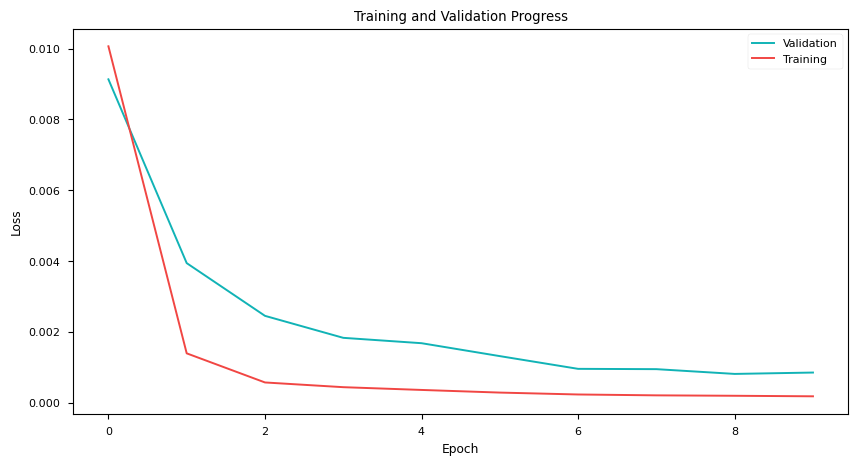

In [32]:
# 构造参数字典
params3 = {
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 10,
    "input_dim": 1,
    "out_dim": 1,
    "verbose": True,
    "plots": True,
}
pretrained_model = train(**params3)

### 定义迁移学习模型

In [36]:
def train(pretrained_model, train_loader, valid_loader, n_epochs, verbose=True, plots=True):
    # 定义迁移学习模型，在原始模型后面添加新的层
    class TransferLearningModel(nn.Module):
        def __init__(self, pretrained_model, hidden_dim):
            super(TransferLearningModel, self).__init__()
            self.pretrained_model = pretrained_model
            self.activation = nn.ReLU()
            self.output_layer1 = nn.Linear(pretrained_model.linear.out_features, hidden_dim)
            self.output_layer2 = nn.Linear(hidden_dim, 1)

        def forward(self, x):
            x = self.pretrained_model(x)
            x = self.activation(x)
            x = self.output_layer1(x)
            x = self.activation(x)
            x = self.output_layer2(x)
            return x
        
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    #训练模型
    hidden_dim = 32
    model = TransferLearningModel(pretrained_model, hidden_dim).to(device)
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()

    # 损失函数值
    train_losses, val_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch)
            outputs = outputs[:,-1, -1:] # 取最后一个值，并将其变为二维
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)[:,-1, -1:]
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    #绘制损失函数图
    if plots:
        plot_loss(train_losses, val_losses)
    return model

 10%|████████▎                                                                          | 1/10 [00:01<00:17,  1.99s/it]

Epoch [1/10], Training Loss: 0.0012, Validation Loss: 0.0008


 20%|████████████████▌                                                                  | 2/10 [00:03<00:15,  1.98s/it]

Epoch [2/10], Training Loss: 0.0002, Validation Loss: 0.0007


 30%|████████████████████████▉                                                          | 3/10 [00:06<00:14,  2.05s/it]

Epoch [3/10], Training Loss: 0.0002, Validation Loss: 0.0007


 40%|█████████████████████████████████▏                                                 | 4/10 [00:08<00:12,  2.15s/it]

Epoch [4/10], Training Loss: 0.0002, Validation Loss: 0.0007


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:10<00:11,  2.21s/it]

Epoch [5/10], Training Loss: 0.0002, Validation Loss: 0.0007


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:12<00:08,  2.22s/it]

Epoch [6/10], Training Loss: 0.0002, Validation Loss: 0.0007


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:15<00:06,  2.22s/it]

Epoch [7/10], Training Loss: 0.0002, Validation Loss: 0.0007


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:17<00:04,  2.22s/it]

Epoch [8/10], Training Loss: 0.0002, Validation Loss: 0.0007


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:19<00:02,  2.24s/it]

Epoch [9/10], Training Loss: 0.0002, Validation Loss: 0.0007


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.19s/it]

Epoch [10/10], Training Loss: 0.0002, Validation Loss: 0.0008


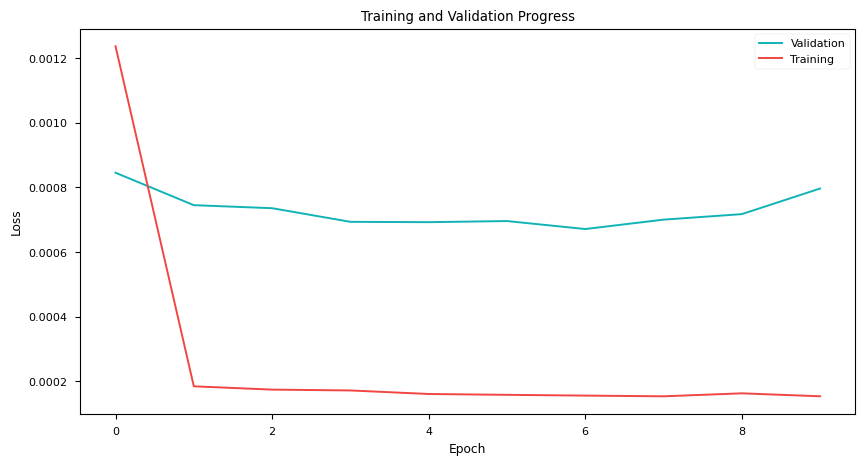

In [37]:
# 构造参数字典
params3 = {
    "pretrained_model": pretrained_model,
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 10,
    "verbose": True,
    "plots": True,
}
model = train(**params3)

## 模型预测

In [38]:
def predict(model, X_train, X_valid, X_test, y_true, lookback, delay, scaler):
    lookback = lookback - 1 #包含当前时间点
    #数据集长度
    train_size = len(X_train) + lookback + delay
    valid_size = len(X_valid) + lookback + delay
    test_size = len(X_test) + lookback + delay
    
    #时间序列形状
    timeseries_y = y_true.values
    timeseries_x = y_true.index
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    #关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        X_train = X_train.to(device) #将数据应用到GPU
        y_pred = model(X_train)
        y_pred = y_pred
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        train_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        train_plot_x = timeseries_x[: train_size]
        '''验证集设置'''
        X_valid = X_valid.to(device)
        y_pred = model(X_valid)
        y_pred = y_pred
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        valid_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        X_test = X_test.to(device)
        y_pred = model(X_test)
        y_pred = y_pred
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        test_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, )) + [np.nan]*(delay-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

In [39]:
# 构造参数字典
params4 = {
    "model": new_model,
    "X_train": X_train,
    "X_valid": X_valid,
    "X_test": X_test,
    "y_true": ts_data[['temp']],
    "lookback": 6,
    "delay": 1,
    "scaler": scaler,
}
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    **params4)

## 结果分析

In [40]:
# 局部静态图
def static_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y):
    timeseries_x = timeseries_x[timeseries_x >= test_plot_x[0]]
    timeseries_y = timeseries_y[timeseries_y.shape[0] - len(test_plot_x):,:]
    #绘图，原始图，训练图，验证图，测试图
    fig = plt.figure(1, (10, 5))
    ax = fig.add_subplot(1,1,1)
    plt.style.use('seaborn-v0_8-paper') #绘制背景色
    plt.grid(axis = 'y',linewidth=0.35) #绘制网格
    plt.title('true-predict-curve ') #图标题
    plt.xticks(rotation = 45) #rotation文字旋转方向
    ax.plot(timeseries_x, timeseries_y, linestyle='-',label = 'true_curve')
    ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'predict_curve')
    ax.legend(frameon=False) #绘制图例
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.show()

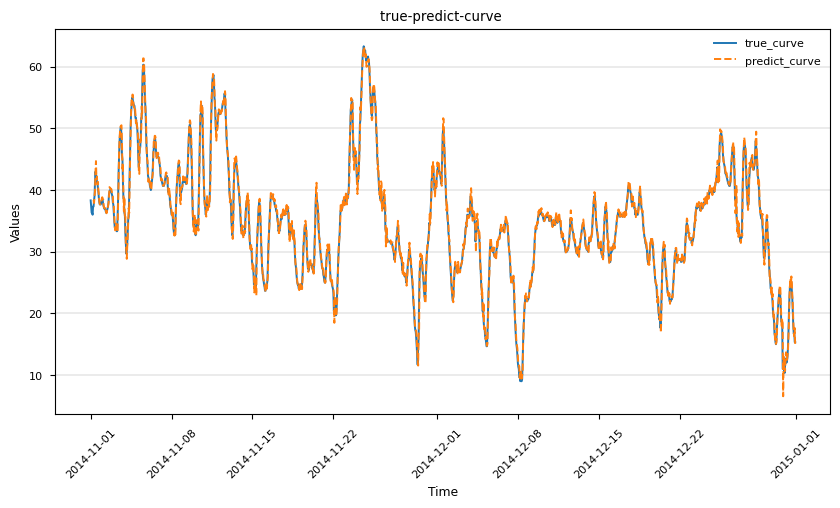

In [41]:
# 局部静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_part_timeseries(**params5)